### LBM D1Q3 Code Example

Target equation: Pseudo-time formulation of 1D linear elastostatics: $\partial_t u = E \partial_x^2 u + b$ in $(x,t)\in(0,L)\times(0,t_{max})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from IPython.display import HTML
import sympy as sp

## Problem Definiton

Define Young's modulus $E$, domain length $L$ and maximum time $t_{max}$

In [2]:
E = 0.07
L = 1.0
t_max = 0.8

Initialize with a Gauss distribution: $u_0(x) = \exp{\left[-\left(\frac{x-x_{max}}{s}\right)^2\right]}$

In [3]:
def ic(x):
    x_max = 0.5
    s = 0.1
    return np.exp(-((x - x_max) / s) ** 2)

Define body load term $b(x)$ ($=0$ in the first example)

In [4]:
def b(x,t):
    return 0

## Numerical parameters
Define number of lattice nodes $nx$, number of time steps $nt$ and $\theta\in[0,1]$ to determine the relative weighting between the rest population and the moving populations. For $\theta=1$ D1Q2 is retrieved.

In [5]:
nx = 32
nt = 800
theta = 1/3

## Preprocessing
 - Determine lattice spacing $\Delta x = L/nx$ and time step size $\Delta t = t_{max}/nt$
 - Calculate the relaxation time $\tau = \frac{E \Delta t}{\Delta x^2} + \frac{1}{2}$
 - Generate grid with half lattice spacing offset: $x_{domain} = \{1/2\Delta x, 3/2\Delta x, \dots, L-1/2\Delta x\}$

In [6]:
dx = L/nx;
dt = t_max/nt;
tau = E*dt/(theta*dx**2)+0.5;
x_domain = np.arange(dx / 2, L, dx)

## Equilibrium
Define the local equilibrium $f^{eq}_i(u) = u/2, \quad i={-1,1}$

In [7]:
def feq(u, theta):
    return np.array([
        (1 - theta) * u,
        (theta / 2) * u,
        (theta / 2) * u
    ])

## Definition of a single LBM time step
 - Compute zeroth-order moment $u^{num} = \sum_i f_i$
 - Perform collision
 - Perform streaming
 - Apply periodic boundary conditions

In [8]:
def timestep(f, tau, phi_dt):
    unum = np.sum(f, axis=0)
    fpost = feq(unum, theta)/tau + (1-1/tau)*f
    fpost[0,:] = fpost[0,:] + phi_dt

    f[0,:] = fpost[0,:]
    f[1,1:] = fpost[1,:-1]
    f[2,:-1] = fpost[2,1:]

    f[1,0] = fpost[1,-1]
    f[2,-1] = fpost[2,0]
    
    return f, unum

## Time step loop

 - Initialize populations at equilibrium of the initial condition: $f_i(x,0) = f_i^{eq}(u_0(x)), \quad i={-1,1}$
 - Execute lattice Boltzmann method for $nt$ time steps
 - Output $u^{num}$ with given output interval and output times

In [9]:
def lbm(x_domain, dt, nt, tau, theta, output_interval=10):
    """
    Run LBM simulation but store outputs only at the first, last, and every output_interval step.
    """
    
    # Determine which timesteps to store
    if nt > 2:
        output_times = np.unique(
            np.concatenate(([0],
                            np.arange(output_interval, nt, output_interval),
                            [nt - 1]))
        )
    else:
        output_times = np.arange(nt)
    
    # Preallocate for only saved outputs
    n_outputs = len(output_times)
    u_out = np.zeros((n_outputs, len(x_domain)))
    
    # Initialize distribution function
    f = feq(ic(x_domain), theta)
    
    # Simulation loop
    out_idx = 0
    for it in range(nt):
        phi = b(x_domain, it * dt)
        f, u = timestep(f, tau, phi * dt)
        
        # Save only at selected intervals
        if it in output_times:
            u_out[out_idx, :] = u
            out_idx += 1
    
    return u_out, output_times

In [10]:
u_out, output_times = lbm(x_domain, dt, nt, tau, theta, 100)

## Visualization

Create animation of $u^{num}$

In [11]:
def animate_lbm_outputs(x_domain, u_out, output_times, u_out2=None, labels=("u₁", "u₂")):
    """
    Animate LBM output arrays (u_out, optionally u_out2) over x_domain,
    using provided output_times for the frame labels.
    """
    n_outputs, nx = u_out.shape

    # --- Set up figure ---
    fig, ax = plt.subplots(figsize=(6, 4))
    line1, = ax.plot([], [], lw=2, label=labels[0])
    line2 = None
    if u_out2 is not None:
        line2, = ax.plot([], [], lw=2, label=labels[1], linestyle="--")

    # Auto scale y-axis to fit both datasets if provided
    u_min = np.min(u_out)
    u_max = np.max(u_out)
    if u_out2 is not None:
        u_min = min(u_min, np.min(u_out2))
        u_max = max(u_max, np.max(u_out2))

    ax.set_xlim(x_domain[0], x_domain[-1])
    ax.set_ylim(1.1*u_min, 1.1*u_max)
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.grid(True)
    if u_out2 is not None:
        ax.legend()

    # --- Initialization ---
    def init():
        line1.set_data([], [])
        if line2:
            line2.set_data([], [])
        return (line1, line2) if line2 else (line1,)

    # --- Frame update ---
    def update(frame_idx):
        line1.set_data(x_domain, u_out[frame_idx, :])
        if line2 is not None:
            line2.set_data(x_domain, u_out2[frame_idx, :])
        ax.set_title(f"timestep = {output_times[frame_idx]}")
        return (line1, line2) if line2 else (line1,)

    # --- Animation ---
    ani = FuncAnimation(fig, update, frames=n_outputs, init_func=init,
                        blit=True, interval=100, repeat=False)
    plt.close(fig)  # prevent duplicate static plot

    return HTML(ani.to_jshtml())

In [12]:
animate_lbm_outputs(x_domain, u_out, output_times)

# Convergence study

## Manufactured Solutions

For a given target solution $\hat{u}(x,t)$ generate the corresponding source term $b(\hat{u})$ by introducing $\hat{u}$ into the target equation: $b(\hat{u}) = \partial_t \hat{u} - E \partial_x^2 \hat{u}$.

In [13]:
x, t = sp.symbols('x t')
u_sym = sp.sin(2 * sp.pi * (x - t / 3))
u_hat = sp.lambdify((x, t), u_sym, 'numpy')

In [14]:
b_sym = sp.diff(u_sym,t) - E*sp.diff(u_sym,x,2)
b = sp.lambdify((x, t), b_sym, 'numpy')

Define the initial condition based on the manufactured solution: $u_0(x) = \hat{u}|_{t=0}$

In [15]:
ic = lambda x: u_hat(x, 0)

Perform the lattice Boltzmann method with the body force $b(\hat{u})$ and initial condition $u_0$

In [16]:
u_out, output_times = lbm(x_domain, dt, nt, tau, theta, 100)

Evaluate the manufactured solution at the output_times and compare the numerical and exact solution

In [17]:
def evaluate_u_exact(x_domain, output_times, dt):
    u_ex = np.zeros((len(output_times), len(x_domain)))
    out_idx = 0
    for it in output_times:
        u_ex[out_idx,:] = u_hat(x_domain, it*dt)
        out_idx += 1

    return u_ex

In [18]:
u_ex = evaluate_u_exact(x_domain, output_times, dt)
animate_lbm_outputs(x_domain, u_out, output_times, u_ex, labels=("$u^{num}$", "$u^{exact}$"))

Calculate the grid L2 and Linf norm of the error at the final time: $L_p[(u^{num} - u^{exact})(x,t_{max})], \quad p\in\{2,\infty\}$

In [19]:
def l2_norm(u_error, dx):
    return np.sqrt(dx) * np.linalg.norm(u_error)
def linf_norm(u_error):
    return np.max(np.abs(u_error))

Output the relative L2 and Linf error (normalized by the L2 norm of the exact solution)

In [20]:
l2 = l2_norm(u_out[-1,:] - u_ex[-1,:], dx) / l2_norm(u_ex[-1,:], dx)
linf = linf_norm(u_out[-1,:] - u_ex[-1,:]) / l2_norm(u_ex[-1,:], dx)
print(f"l2 = {l2}")
print(f"linf = {linf}")

l2 = 0.0037222149595777616
linf = 0.005262599440548873


## Grid convergence study
 - Define a base discretization and a sequence of refinement factors $rf$
 - Determine $\Delta x$ and $\Delta t$ according to the diffusive scaling
 - Evaluate the lattice Boltzmann method for each refinement factor
 - Determine the exact solution
 - Calculate L2 and Linf norms for each refinement factor

In [21]:
nx_base = 32
nt_base = 800
rf_list = [1, 1/2, 1/3, 1/4]

In [22]:
def convergence_study(L, t_max, nx_base, nt_base, tau, theta, E, rf_list):
    n_run = len(rf_list)
    l2 = np.zeros(n_run)
    linf = np.zeros(n_run)
    dx_list = np.zeros(n_run)
    
    for i, rf in enumerate(rf_list):
        nx = int(nx_base/rf)
        nt = int(nt_base/rf**2)

        dx = L/nx
        dt = t_max/nt

        x_domain = np.arange(dx / 2, L, dx)
        
        u_out, output_times = lbm(x_domain, dt, nt, tau, theta, output_interval=nt)
        u_ex = evaluate_u_exact(x_domain, output_times, dt)

        l2[i] = l2_norm(u_out[-1,:] - u_ex[-1,:], dx) / l2_norm(u_ex[-1,:], dx)
        linf[i] = linf_norm(u_out[-1,:] - u_ex[-1,:]) / l2_norm(u_ex[-1,:], dx)
        dx_list[i] = dx

    return dx_list, l2, linf

In [23]:
dx_list, l2, linf = convergence_study(L, t_max, nx_base, nt_base, tau, theta, E, rf_list)

Plot the L2 and Linf error over the grid spacing $\Delta x$ in log-log scale

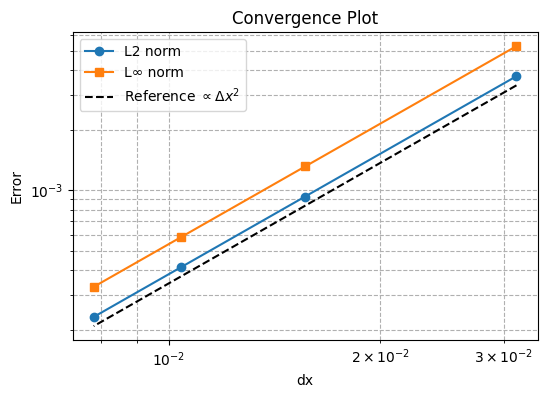

In [24]:
plt.figure(figsize=(6, 4))

plt.loglog(dx_list, l2, 'o-', label='L2 norm')
plt.loglog(dx_list, linf, 's-', label='L∞ norm')

C = l2[0] / dx_list[0]**2
ref_line = 0.9*C * dx_list**2
plt.loglog(dx_list, ref_line, 'k--', label=r'Reference $\propto \Delta x^2$')

plt.xlabel('dx')
plt.ylabel('Error')
plt.title('Convergence Plot')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()